In [12]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lc0sight("../lc0.onnx", device=device)

Using device: cuda


First, we load a dataset of puzzles selected to be challenging but solvable for Leela:

In [14]:
with open("../interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

Let's look at one of these puzzles:

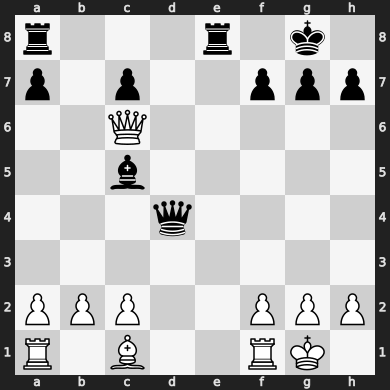

In [15]:
# This is the running example from the paper, you can pick a different one:
puzzle = puzzles.iloc[483]
# LeelaBoard instances can also be created from FENs or in other ways, but always
# use from_puzzle if you want to create one from a puzzle from the lichess dataset.
# board = LeelaBoard.from_puzzle(puzzle)
# board




board = LeelaBoard.from_fen("r3r1k1/p1p2ppp/2Q5/2b5/3q4/8/PPP2PPP/R1B2RK1 b - - 0 14")

corrupted_board = LeelaBoard.from_fen("4r2k/p5bp/6p1/8/3q4/1B4P1/PPb1R2P/4R2K w - - 0 25")
board

The *principal variation* is the best sequence of moves for both sides:

In [231]:
puzzle.principal_variation

['f4g6', 'h7g6', 'd4h4']

Leela solves this puzzle correctly:

In [232]:
model.pretty_play(board)

Qc4: 21.39%
Qxf2+: 19.23%
Bb6: 16.94%
Qe5: 14.04%
Bd6: 9.90%
W: 15.77%, D: 63.29%, L: 20.94%


# Visualizing attention patterns

Next, let's look at some attention patterns. These are 64 x 64 arrays, with one entry for each pair of squares.

In [152]:
layer = 1
head = 4

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

/tmp/ipykernel_32597/998635998.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 12))  # make the figure square for symmetry


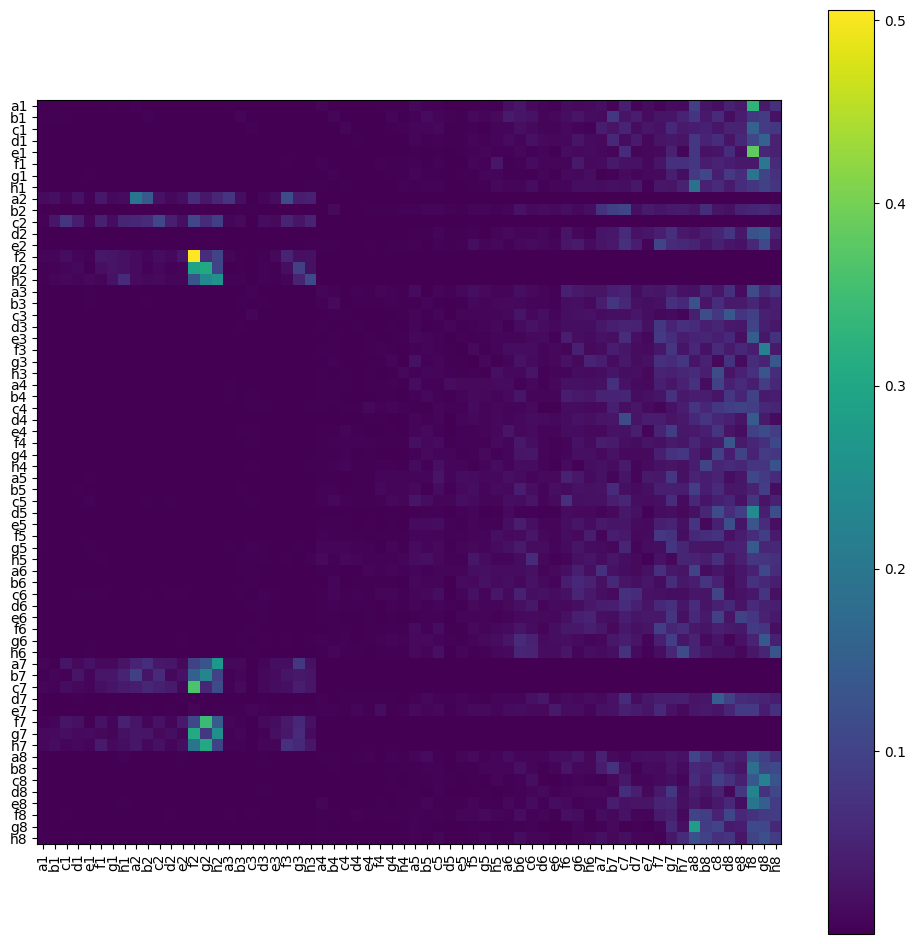

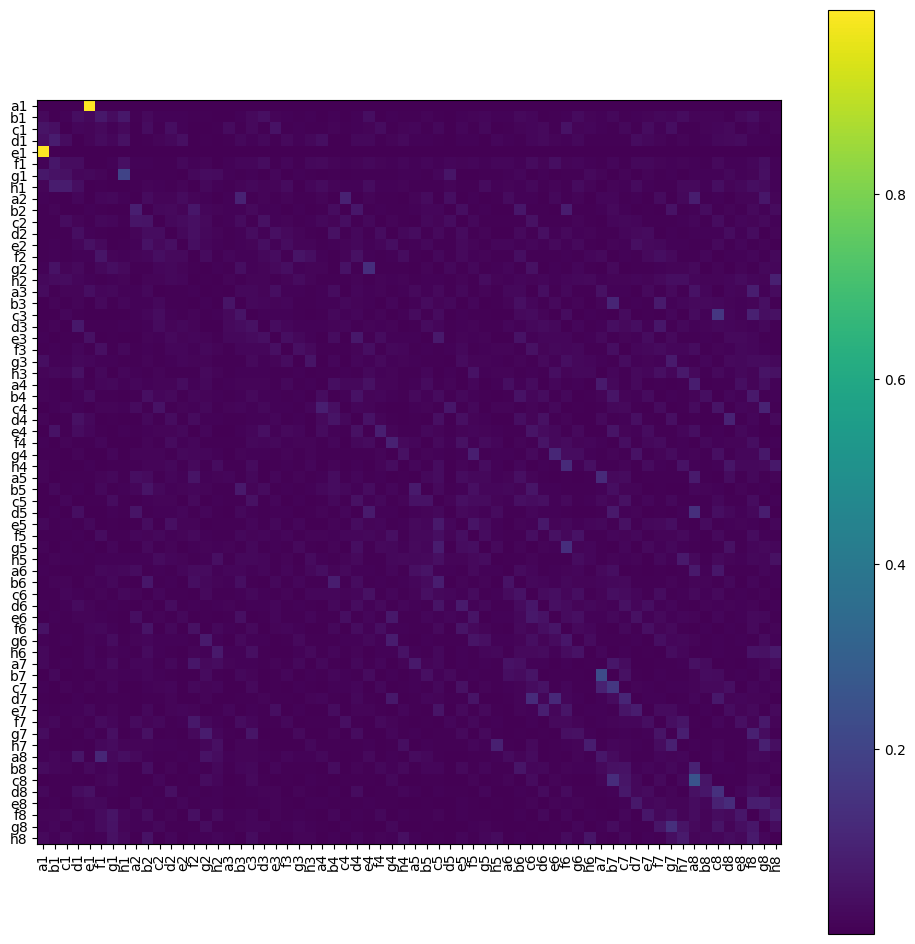

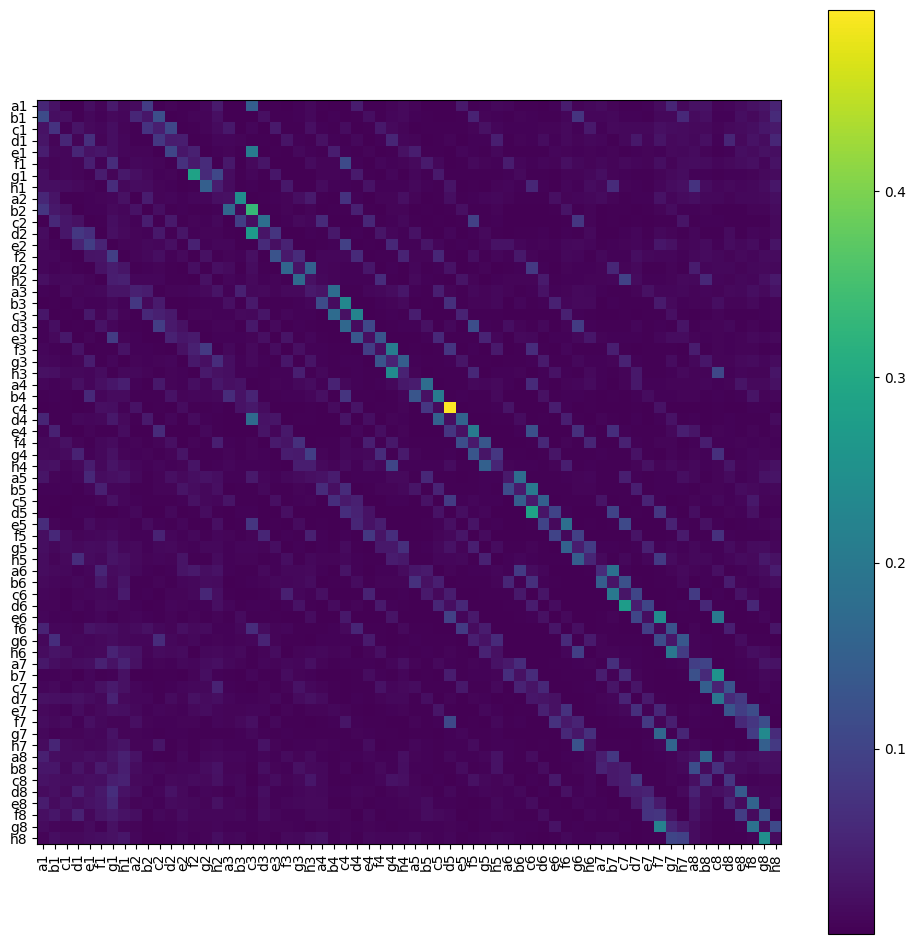

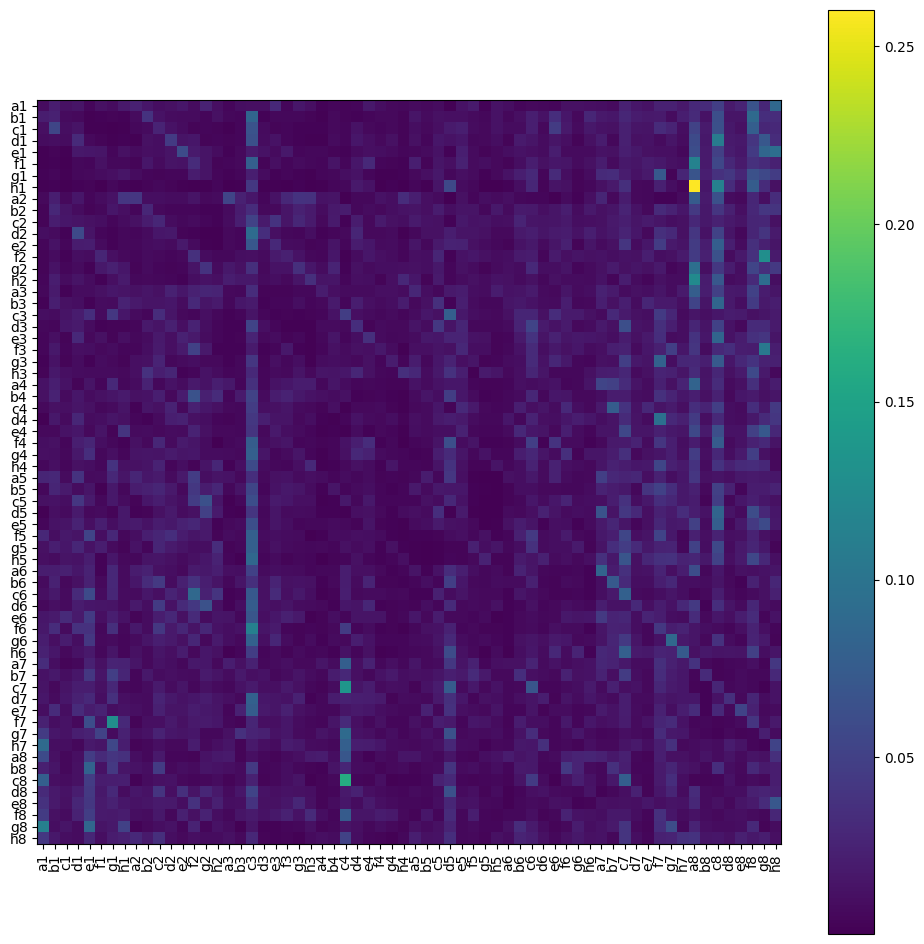

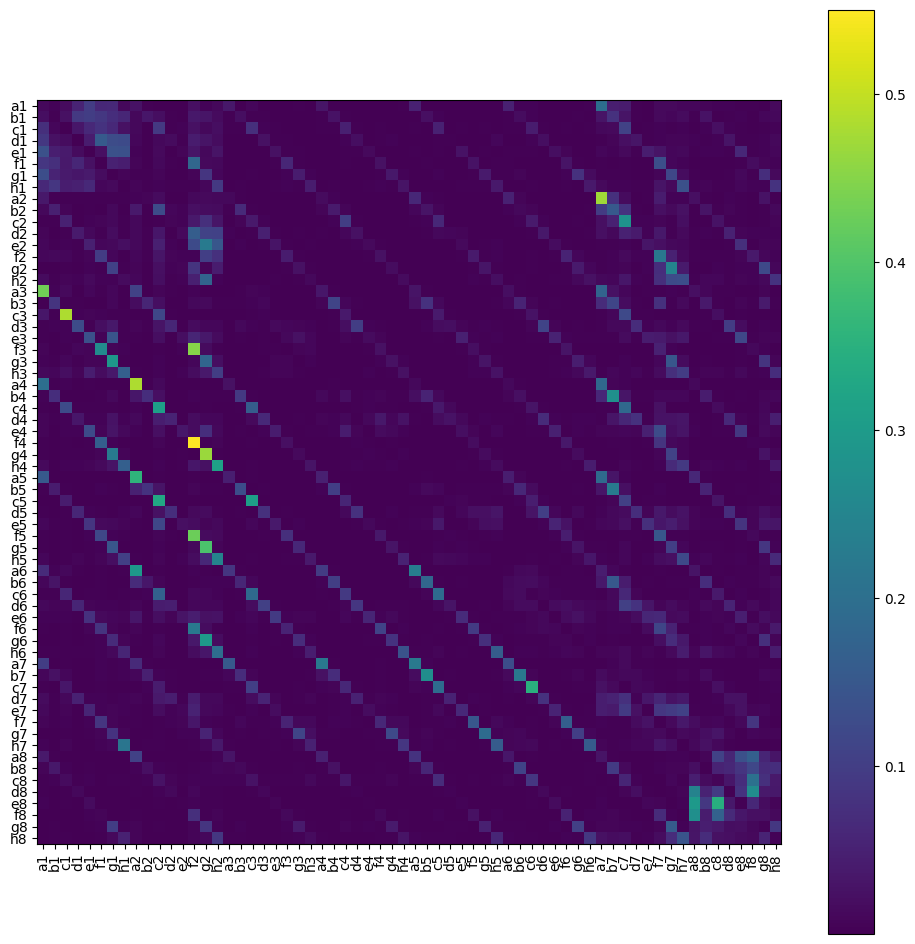

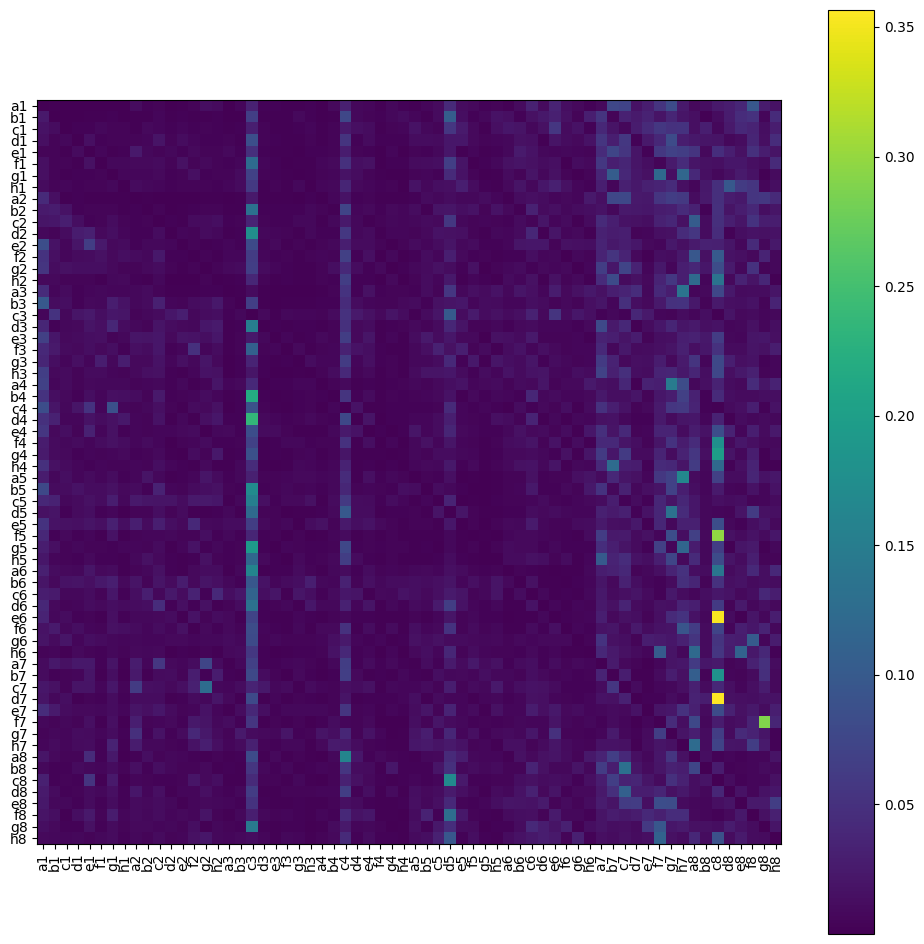

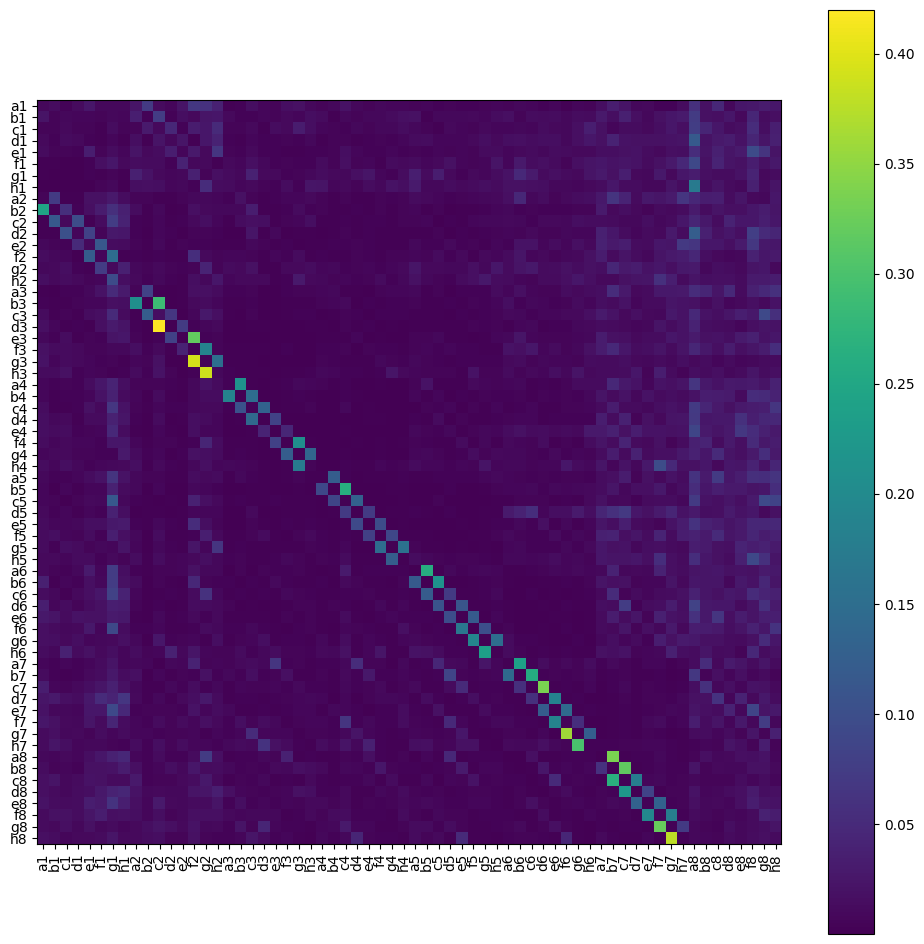

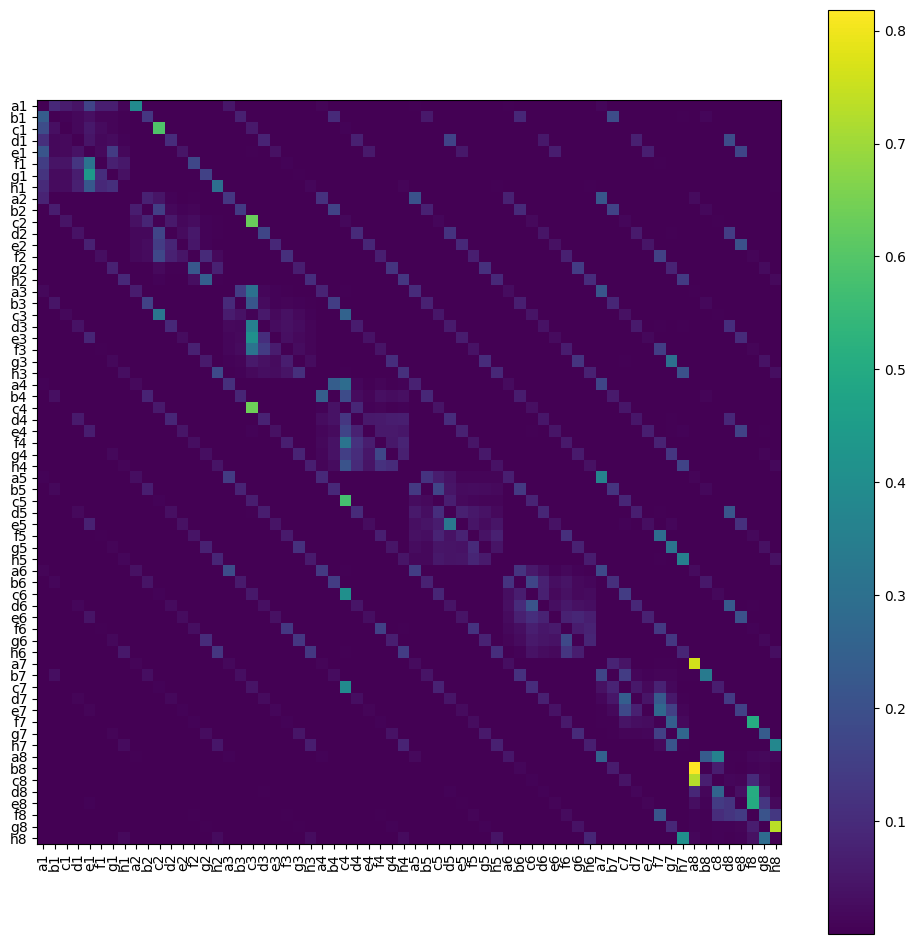

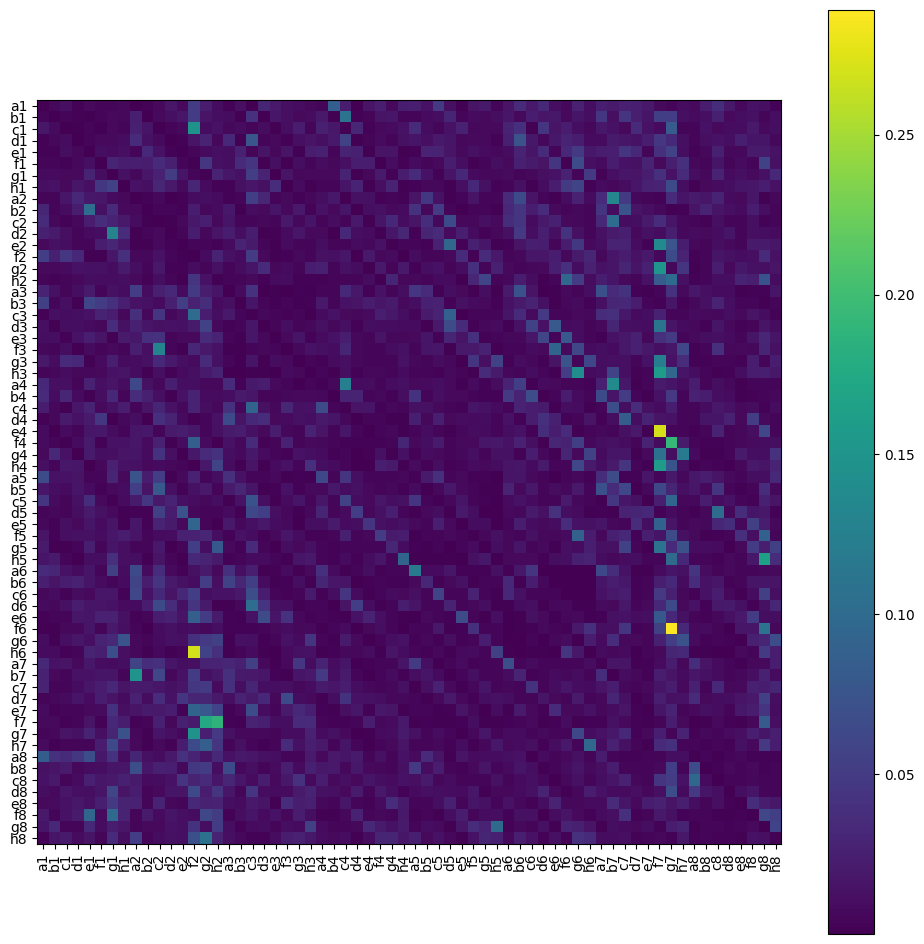

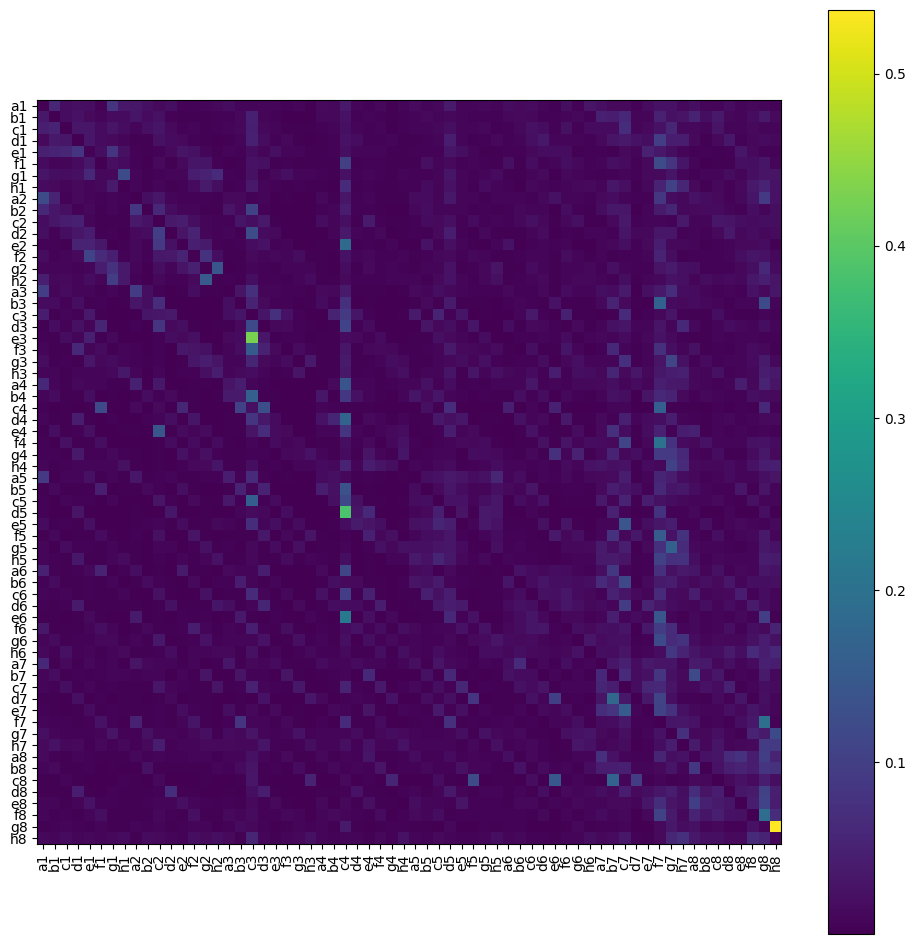

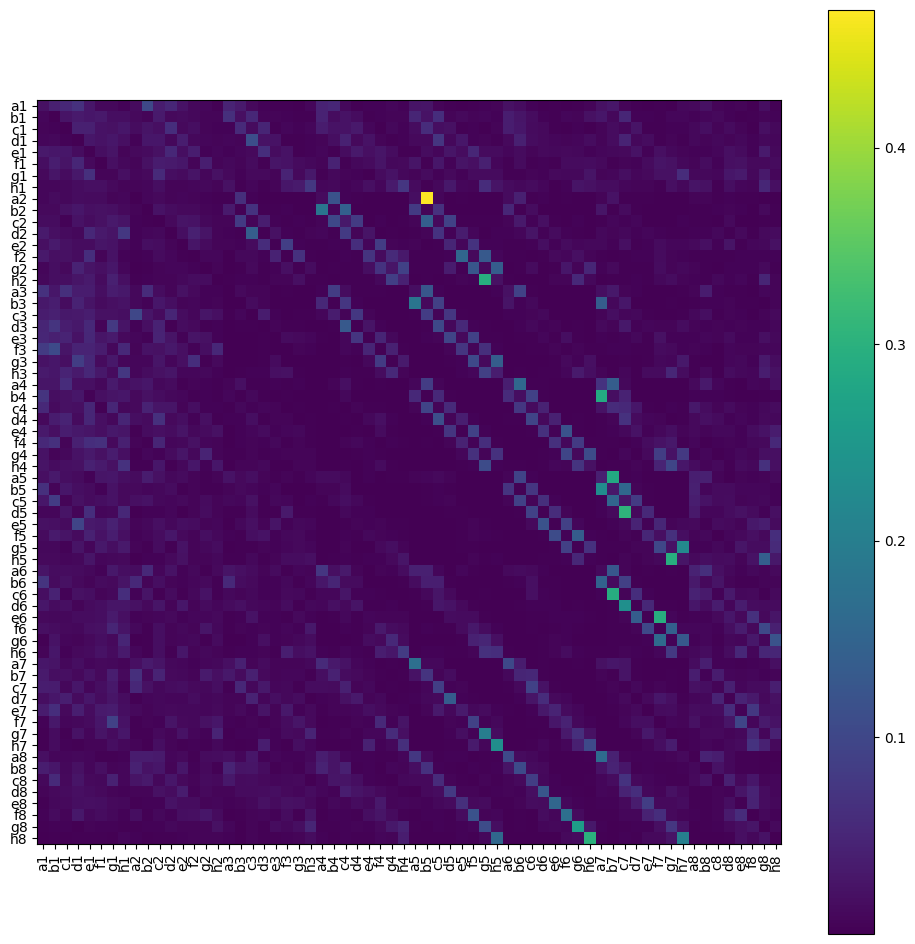

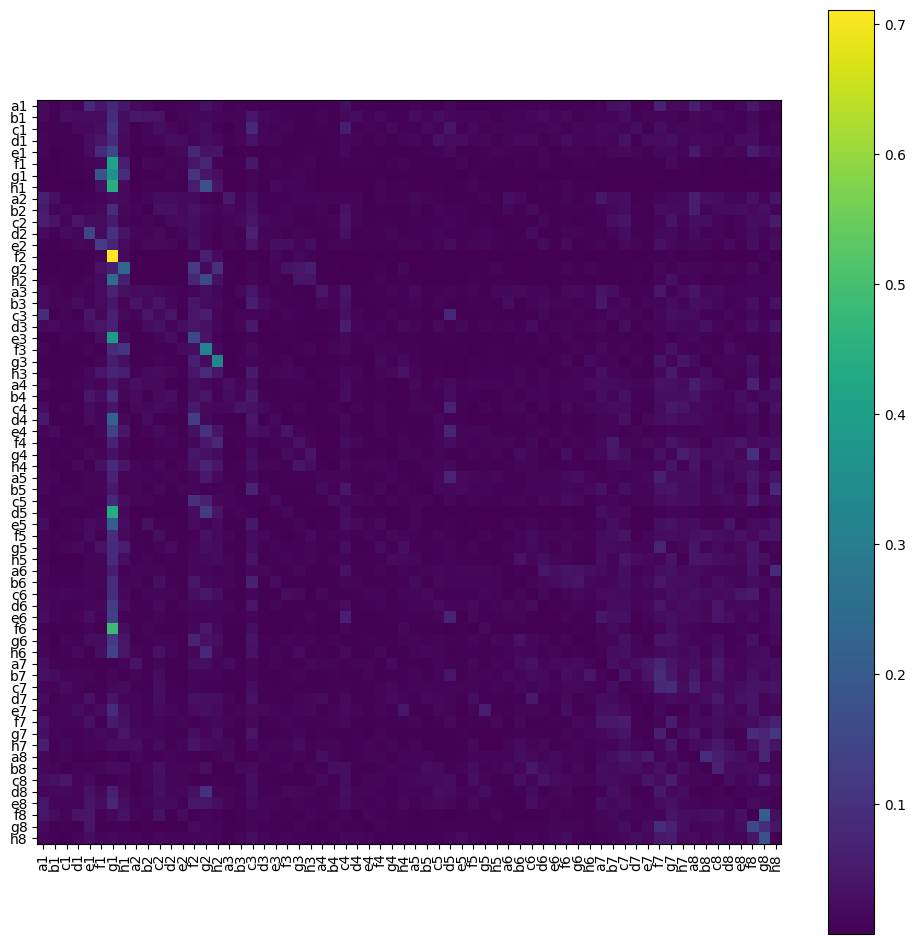

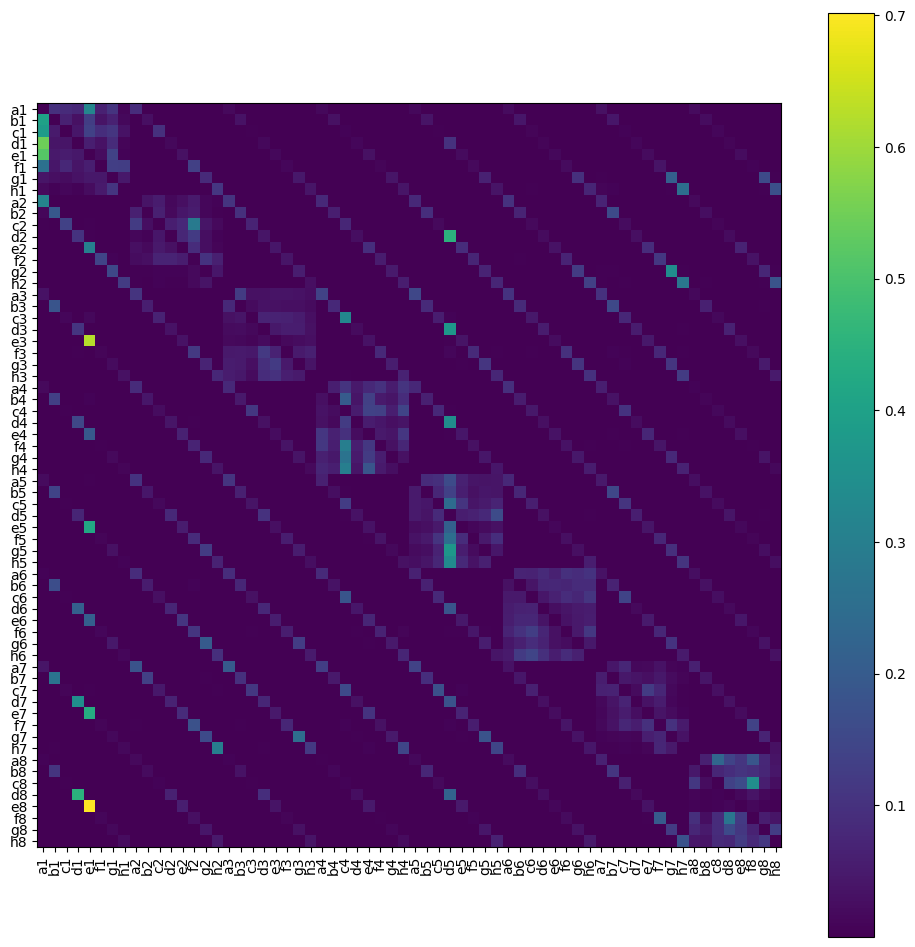

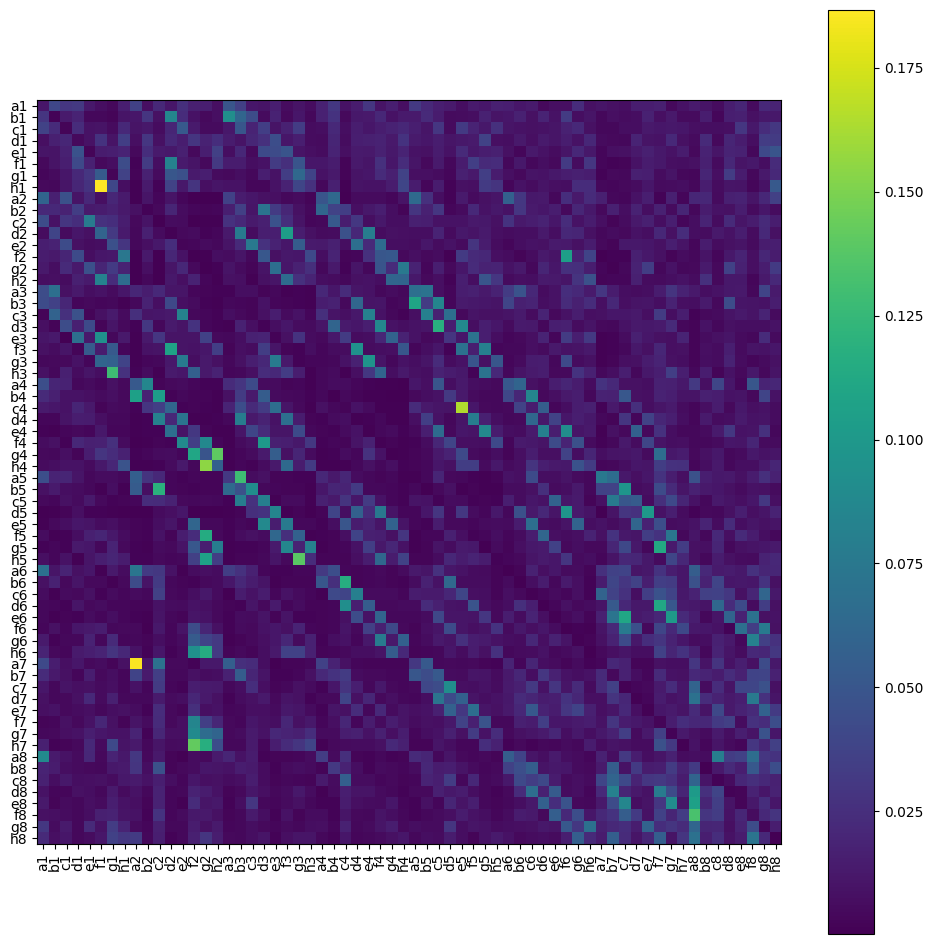

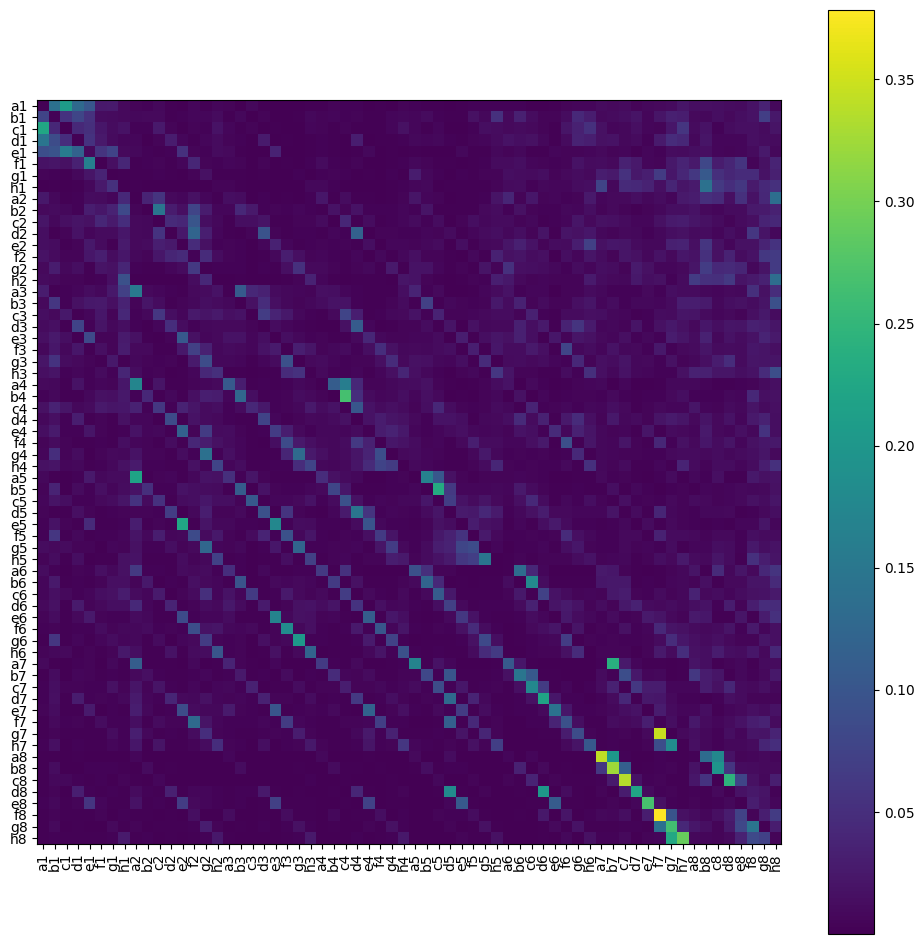

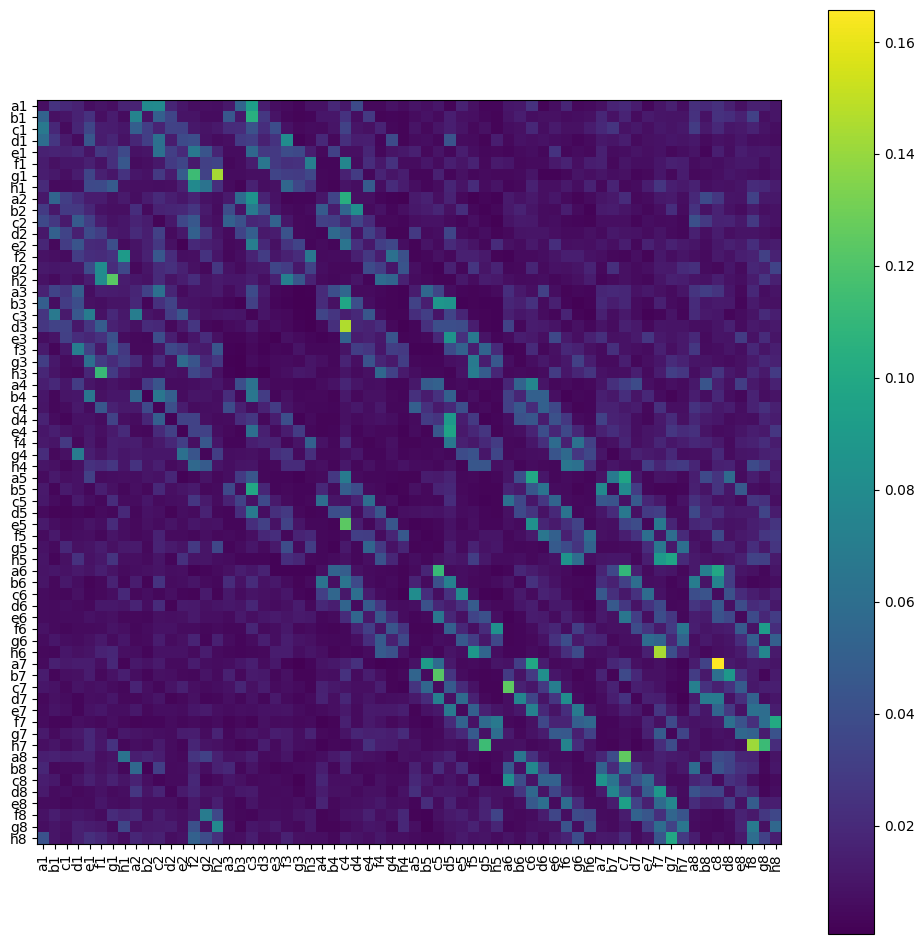

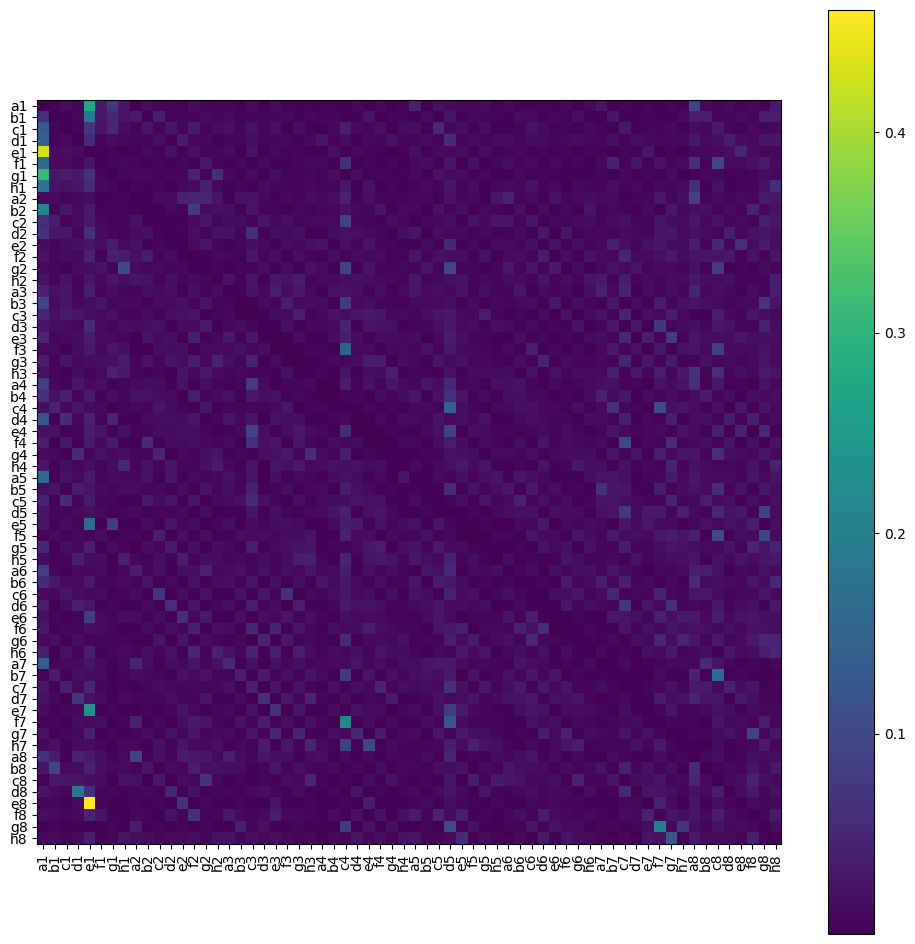

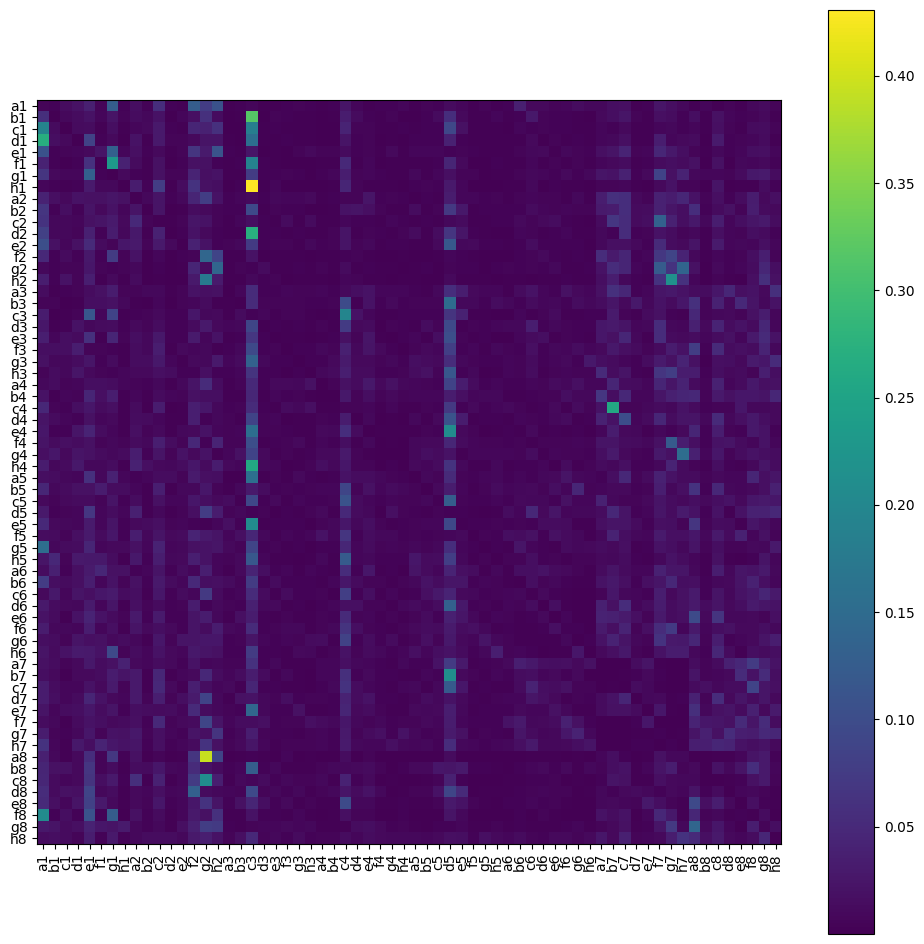

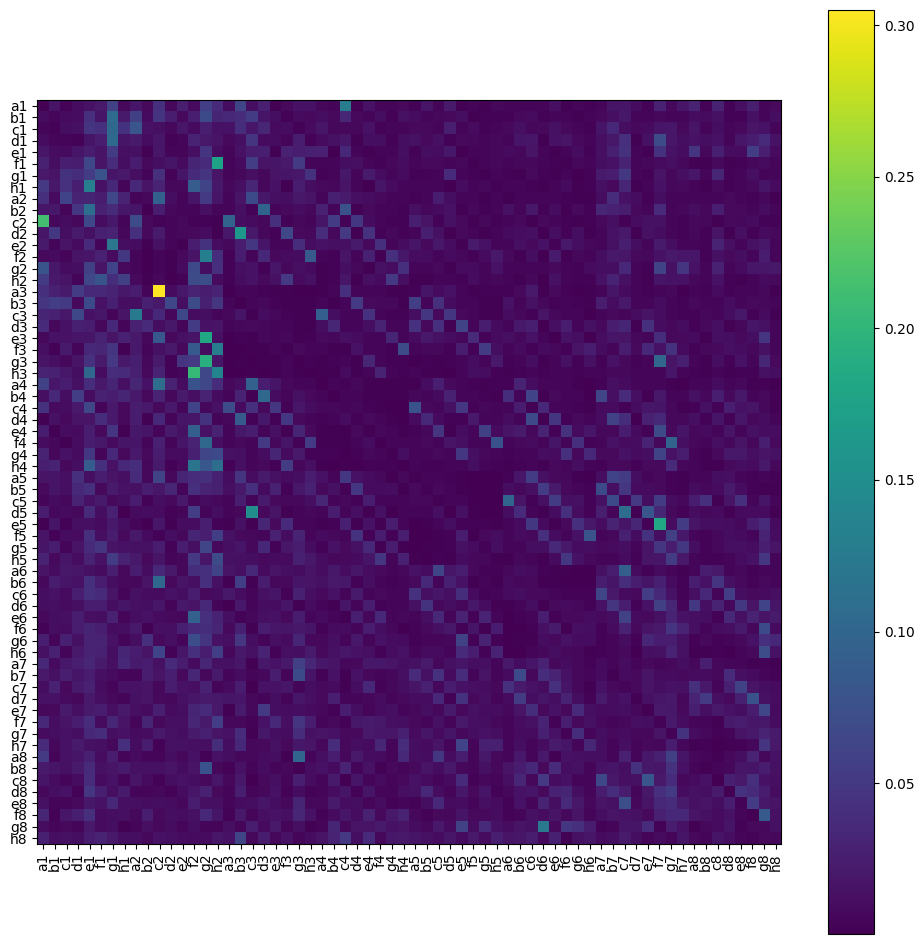

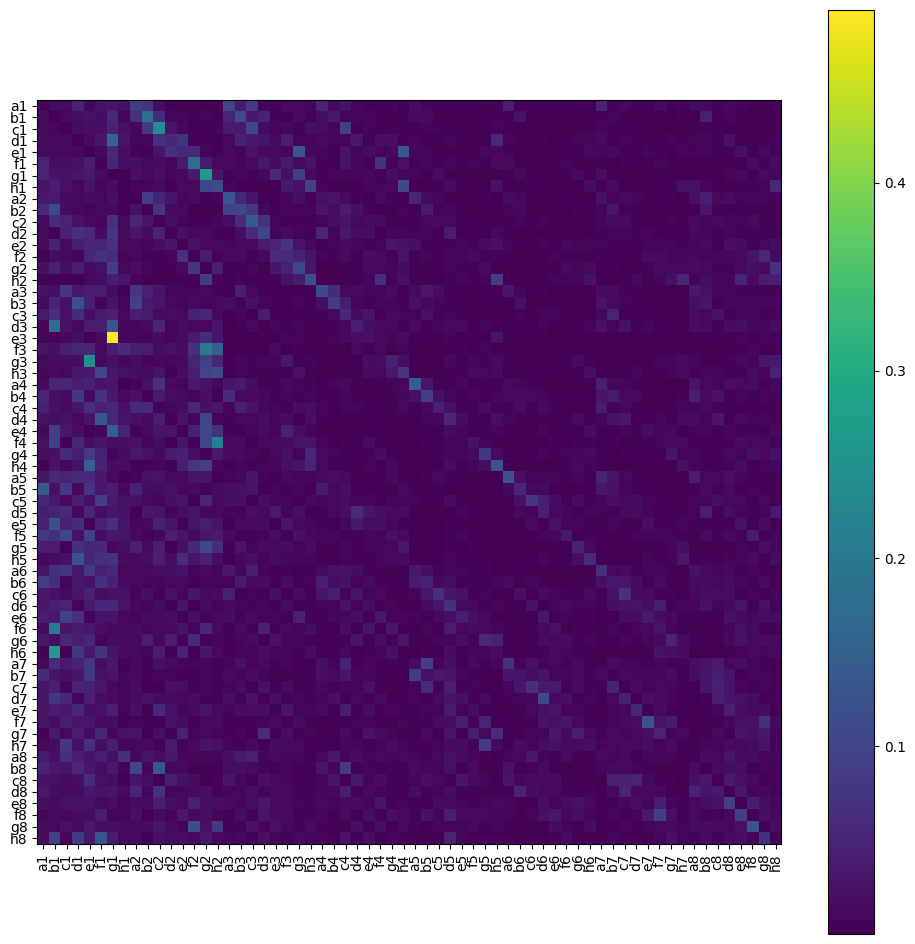

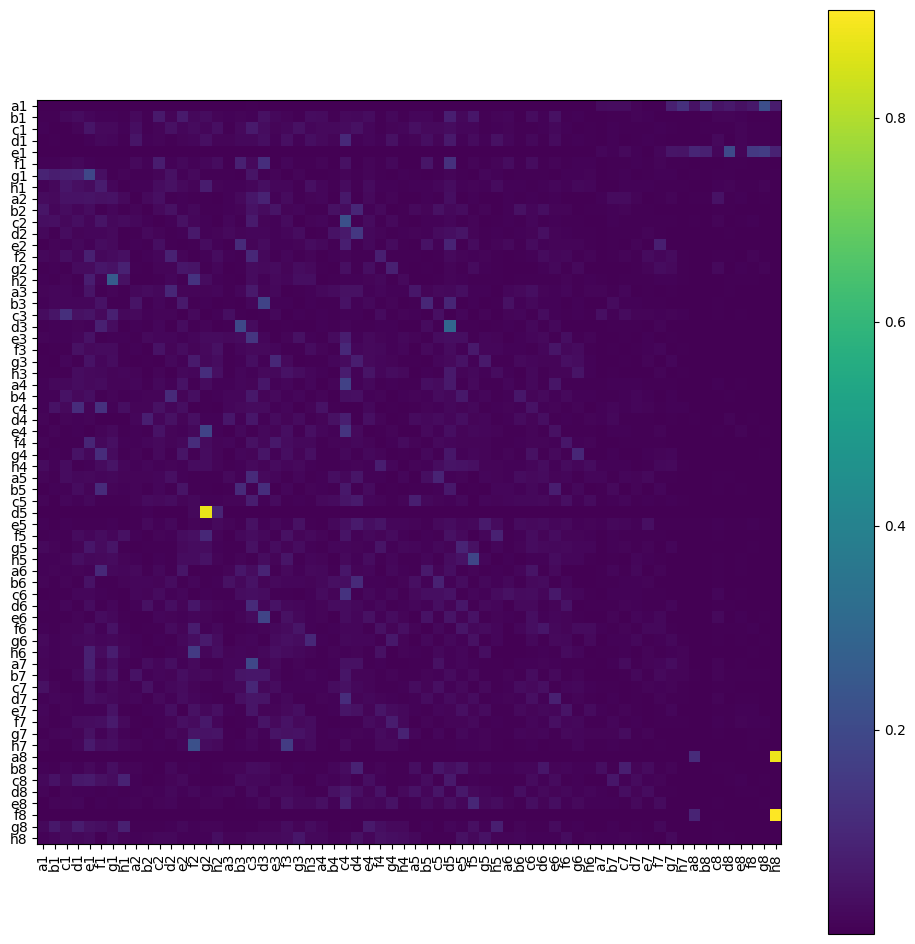

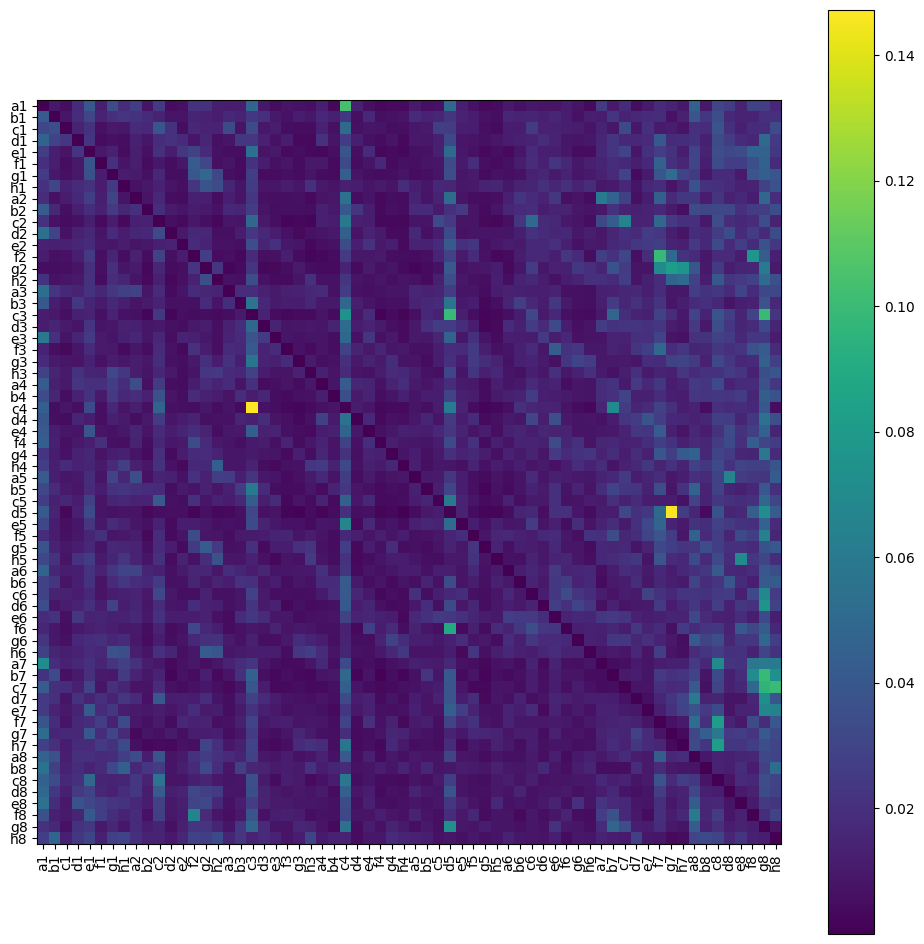

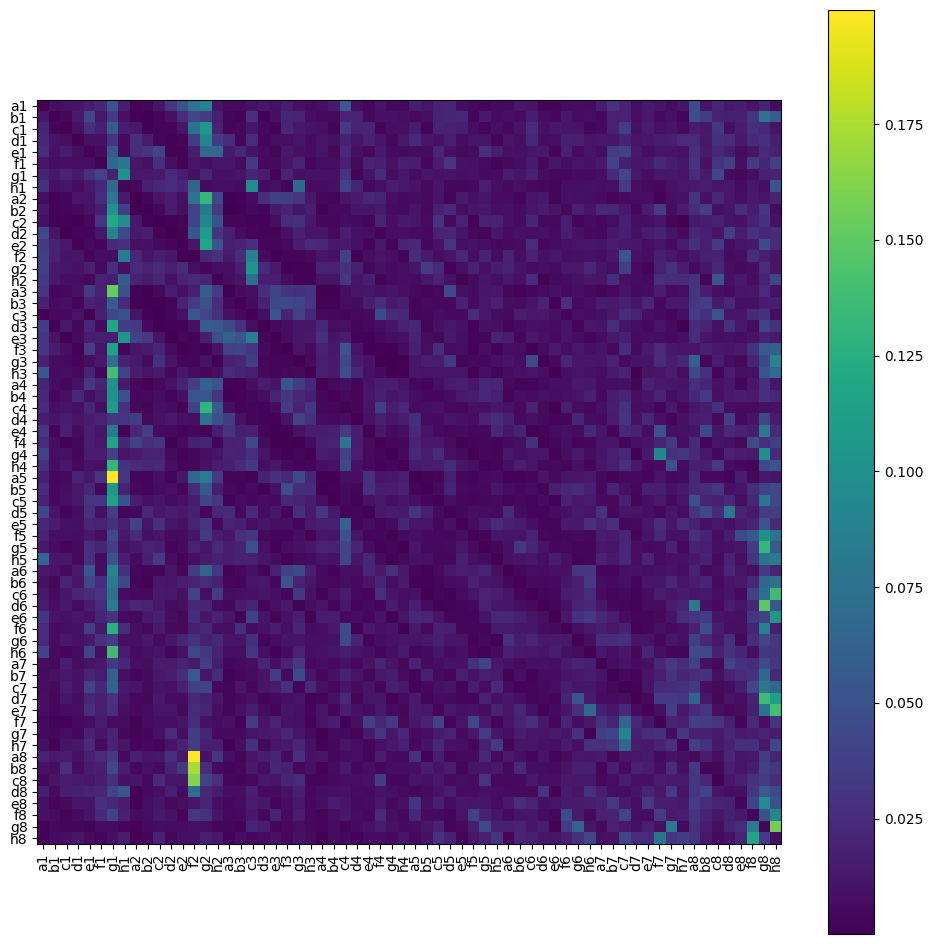

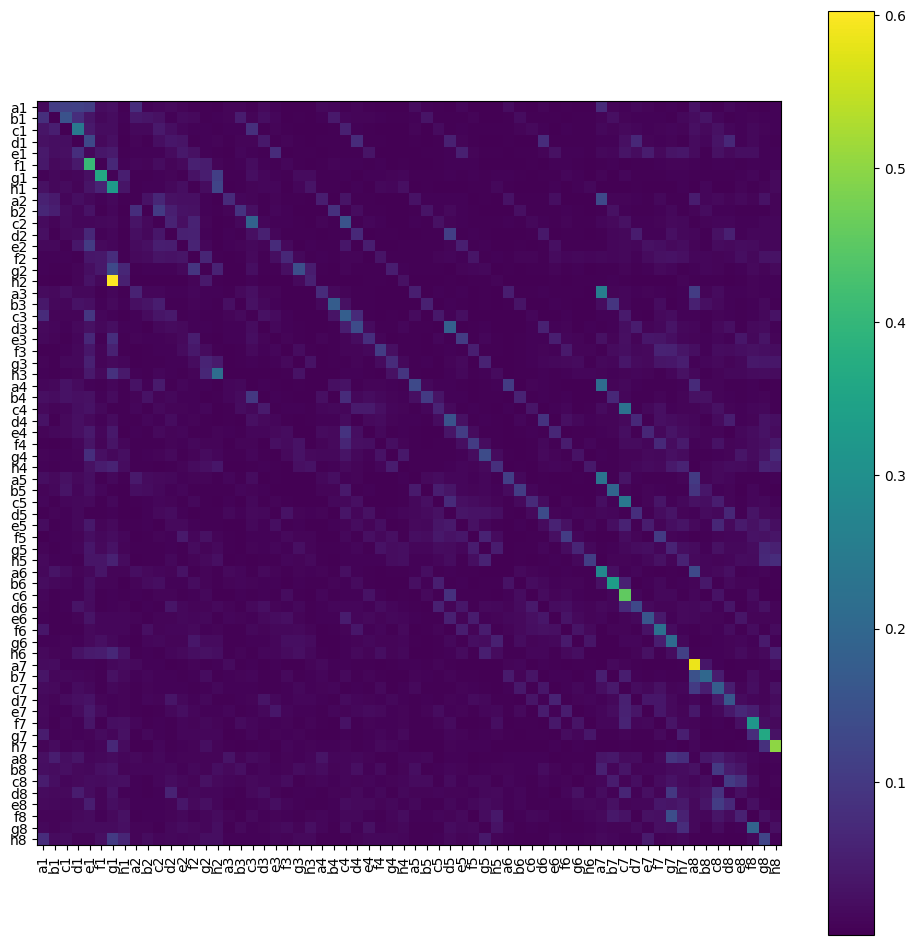

In [233]:
import matplotlib.pyplot as plt
import numpy as np


for head in range(24):
    layer = 2
    # head =
    
    # We're using nnsight to cache activations and do interventions. There's also an interface
    # based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
    with model.trace(board):
        attention = model.attention_scores(layer).output[0, head].save()
    attention.shape

    # assuming your matrix is called 'matrix'
    matrix = attention.cpu() # replace this with your actual data
    
    # create chess square labels
    squares = [chr(ord('a') + i % 8) + str(i // 8 + 1) for i in range(64)]
    
    plt.figure(figsize=(12, 12))  # make the figure square for symmetry
    
    # set ticks and labels
    plt.xticks(ticks=np.arange(64), labels=squares, rotation=90)
    plt.yticks(ticks=np.arange(64), labels=squares)
    
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar()  # add color scale



We can plot slices of this attention pattern:

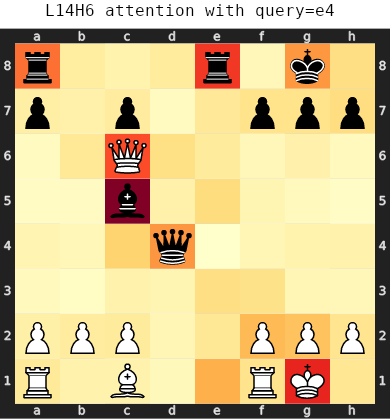

In [16]:
layer = 14
head = 6

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, :].save()
attention.shape

attention = attention.sum(dim=0)

square = "e4"
# This converts a square in chess notation to the index inside Leela's activations for
# that square. Note that the input to Leela is flipped depending on the current player's
# color.
idx = board.sq2idx(square)
# attention has shape (query_dim, key_dim); indexing into the first one gives us a slice
# of the attention pattern with fixed query.
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

# Attention attribution

Let's look at L12H12 instead and do attention attribution (this is basically approximating a zero-ablation of individual attention weights). We'll then plot the entries with the highest attribution scores as arrows from key to query (i.e. in the direction of information flow).

In [238]:
fens = [
    "r3r1k1/p1p2ppp/2Q5/2b5/3q4/8/PPP2PPP/R1B2RK1 b - - 0 14",
    "r4r1k/p1p1Nppp/2Q1p3/4N1q1/3P1n2/2P3n1/PP3P2/R4RK1 w - - 0 23",
    "1rb1kb1r/2qn1ppp/2p2P2/8/4P3/2Q1BN1P/1PP3P1/R3KB1R b KQk - 0 14",
]

results = []
for fen in fens:
    results.append([])
    for i in range(24):
        board = LeelaBoard.from_fen(fen)
        attribution = attention_attribution(
            [board], layer=12, head=i, model=model, return_pt=True
        )[0]
        values, colors = top_k_attributions(attribution, board, k=5)
        results[-1].append(board.plot(arrows=colors))

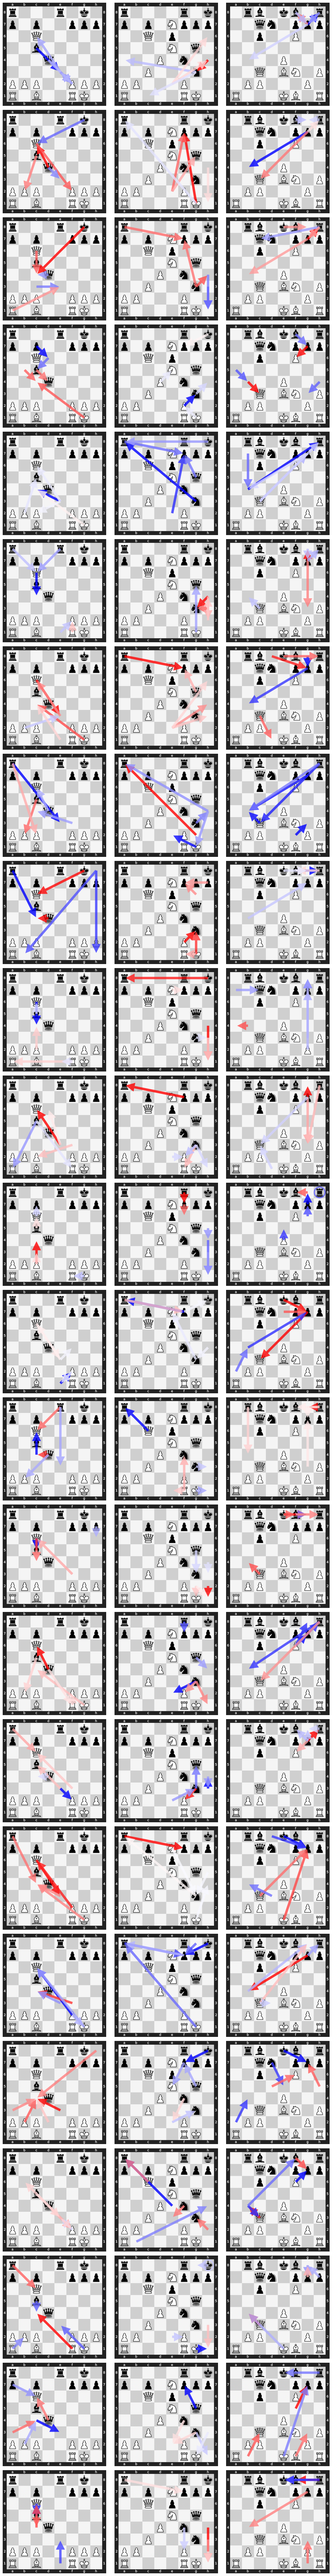

In [239]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# define the number of rows and columns
rows, cols = len(results[0]), len(results)

# set the size of the figure
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols + 1, 4 * rows))  # adjust figsize as needed

# loop over each image and display it in the correct position
for i in range(rows):
    for j in range(cols):
        img = results[j][i].render()
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # hide axes for a cleaner look

plt.tight_layout()  # adjust spacing between images
plt.show()

As discussed in the paper, it seems L12H12 is moving information from the 3rd move target square (h4) to the 1st move target (g6). Let's see what happens if we zero-ablate this single attention pattern entry:

In [160]:
query_square = puzzle.principal_variation[0][2:4]
key_square = puzzle.principal_variation[2][2:4]
query_idx = board.sq2idx(query_square)
key_idx = board.sq2idx(key_square)

with model.trace(board):
    model.attention_scores(12).output[0, 12, query_idx, key_idx] = 0
    output = model.output.save()

probs = model.logits_to_probs(board, output[0])[0]
policy = model.top_moves(board, probs, top_k=5)
print(policy)
print("WDL:", output[1])

{'d5e4': 0.9041581749916077, 'f5e4': 0.06891950964927673, 'f6e6': 0.008288721553981304, 'f6g7': 0.0027803389821201563, 'f6f7': 0.002733337925747037}
WDL: tensor([[0.3504, 0.6315, 0.0181]], device='cuda:0')


The previous top move, Ng6, is now in 4th place at only 16%. Leela also thinks it's worse (the win probability is down to 9.9% from 28.7%).

# Activation patching

Finally, let's do activation patching. Every puzzle in our dataset already has a "corrupted version" that we automatically generated. This is a very similar board position, but with a slight difference that makes the tactic no longer work. Note the new pawn on h6:

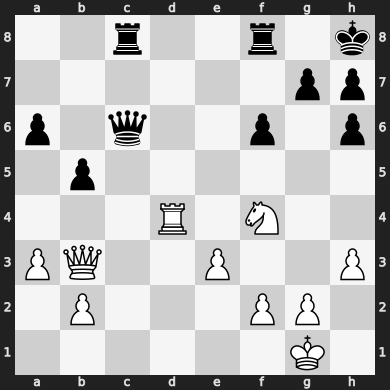

a4: 23.92%
Kh2: 23.56%
Qb4: 13.59%
Qd3: 6.72%
Ne6: 4.85%
W: 1.32%, D: 10.89%, L: 87.79%


In [343]:
corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
display(corrupted_board)
model.pretty_play(corrupted_board)

We could implement activation patching fairly easily with `nnsight`, but we'll instead introduce our patching helper function. Let's patch the output of L12H12 on every square:

In [394]:
log_odds_reductions = -activation_patch(
    module_func=model.headwise_attention_output,
    # Layer, head, output square:
    locations=list(itertools.product([12], [12], range(64))),
    model=model,
    # We could also pass in board and corrupted_board manually instead
    # puzzles=puzzle,
    boards=board,
    corrupted_boards=corrupted_board,
)
log_odds_reductions.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 45.93it/s]


torch.Size([64])

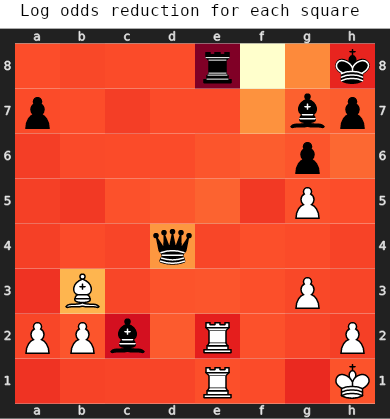

In [395]:
board.plot(log_odds_reductions, caption="Log odds reduction for each square")

As we can see, activation patching essentially only has a big effect on g6, where L12H12 moved information to from h4.

# Next steps
We demonstrated how to use several mechanistic interpretability techniques on a single board position. It's fairly straightforward to extend these to batches of positions, see the files in `scripts` for examples. `nnsight` also makes it quite easy to use other interpretability techniques that we didn't cover here.